# Used cars price prediction - Ironhack midterm project

## 1. EDA

In [1]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import PowerTransformer, StandardScaler, minmax_scale, OneHotEncoder
%matplotlib inline

from scipy.stats import iqr
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

#### EDA results:

* 'car data.csv' has anomalies in feature values; the file is ignored in the analysis due to its low statistical value with only 300 rows.
* 'model' and 'engine' categorical columns have too many unique values; these columns will be ignored for the final data set due to the amount of dummified columns they would create after normalizing the data.
* 'seats' column has nine unique values and will be used as the closest present alternative to vehicle type.
* in order to concatenate the csv files into one dataframe columns 'location', 'color', 'mileage', 'max power', 'max torque', 'drivetrain', 'length', 'width', 'height', 'fuel tank capacity' will be ignored, since they are not present in each file.
* concatenating three csv files will result in a dataframe with roughly over 14k observations.
* no outliers require removal.

In [2]:
df2 = pd.read_csv('../data/Car details v3.csv')
df3 = pd.read_csv('../data/car details v4.csv')

In [3]:
df2.head(1)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0


In [4]:
df3.head(1)

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0


## 2. Data cleaning

#### data cleaning results:
* extracted the first word (Make) in the 'name' and 'owner' columns.
* dropped extra columns.
* formatted 'selling price' column.
* concatenated three files into a new dataframe.
* checked for null values (there aren't any).
* checked for duplicates (2.2k duplicated found) and droppped them.
* check data types (all correct).

In [5]:
df2['name'] = df2['name'].apply(lambda x: x.split()[0])
df2['owner'] = df2['owner'].apply(lambda x: x.split()[0])

In [6]:
df3.rename(columns=
           {"Year": "year",
            "Price": "selling_price",
            "Kilometer": "km_driven", 
            "Fuel Type": "fuel", 
            "Seller Type": "seller_type", 
            "Transmission": "transmission", 
            "Make": "name",
            "Owner": "owner",
            "Seating Capacity": "seats"},inplace=True)

df2["selling_price"] /= 100
df2["selling_price"] = df2["selling_price"].astype(int)

df3["selling_price"] /= 100
df3["selling_price"] = df3["selling_price"].astype(int)

In [7]:
df2.drop(['mileage', 'engine', 'max_power', 'torque'], axis=1, inplace=True)
df3.drop(['Model', 'Location', 'Color', 'Engine', 'Max Power', 'Max Torque', 
          'Drivetrain', 'Length', 'Width', 'Height', 'Fuel Tank Capacity'], axis=1, inplace=True)


In [8]:
df = pd.concat([df2, df3], ignore_index=True)

In [9]:
df['seats'].unique()

array([ 5.,  4., nan,  7.,  8.,  6.,  9., 10., 14.,  2.])

In [10]:
#check for duplicates
dup = df[df.duplicated(keep=False)].sort_values(by=['selling_price'])

In [11]:
#drop duplicates
df.drop_duplicates(inplace=True, ignore_index=True)

In [12]:
#change 'year' to 'age' (and count it)
df.rename(columns={'year': 'age'}, inplace=True)
df['age'] = df['age'].apply(lambda x: df['age'].max()+1-x)

In [13]:
#clean values in 'fuel' column
def clean_fuel(value):
    if 'CNG' in value:
        value = 'CNG'
    elif 'Petrol' in value:
        value = 'Petrol'
    return value

df['fuel'] = df['fuel'].apply(lambda x: clean_fuel(x))

In [14]:
#transform values in 'owner' column
def clean_owner(value):
    if value == 'Test' or value == 'UnRegistered Car':
        value = 0
    elif value == 'First':
        value = 1
    elif value == 'Second':
        value = 2
    elif value == 'Third':
        value = 3
    elif value == 'Fourth':
        value = 4
    elif value == '4 or More':
        value = 5
    return value

df['owner'] = df['owner'].apply(lambda x: clean_owner(x))

In [15]:
#clean 'seller_type' column
def clean_seller(value):
    if 'Dealer' in value:
        value = 'Dealer'
    elif value == 'Commercial Registration':
        value = 'Corporate'
    return value

df['seller_type'] = df['seller_type'].apply(lambda x: clean_seller(x))

In [16]:
df['seats'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8905 entries, 0 to 8904
Series name: seats
Non-Null Count  Dtype  
--------------  -----  
8633 non-null   float64
dtypes: float64(1)
memory usage: 69.7 KB


## Data transformation

#### Results:
* Made plots for km driven, year & selling price.

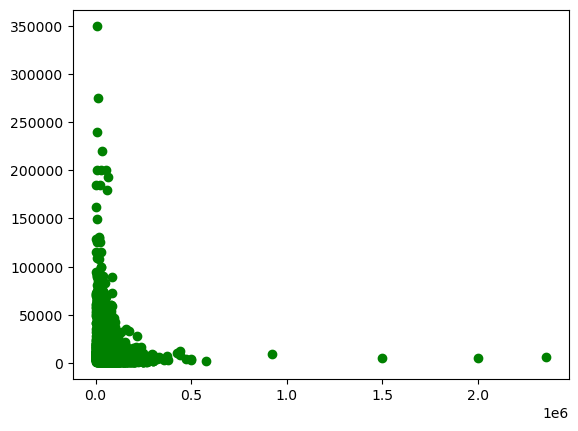

In [17]:
plt.scatter(x=df['km_driven'], y=df['selling_price'],c='g')
plt.show()

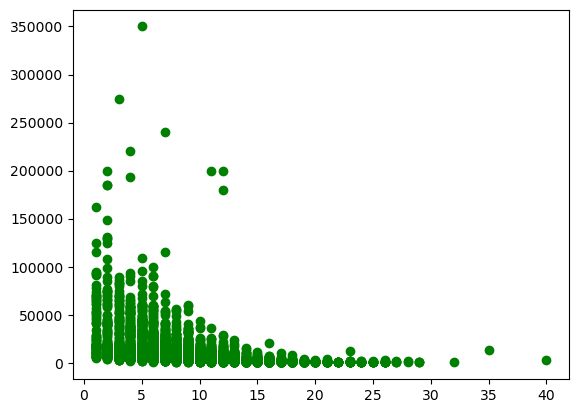

In [18]:
plt.scatter(x=df['age'], y=df['selling_price'],c='g')
plt.show()

#### removing outliers

In [19]:
#remove outliers
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]
    return df

In [20]:
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [21]:
numerical = df.select_dtypes(include=[np.number])
categorical = df.select_dtypes(include=[object])

In [22]:
#numerical = remove_outliers(numerical)
numerical_noseats = numerical.drop(['seats'], axis=1)
numerical_noseats = remove_outliers(numerical_noseats)
numerical_seats = numerical['seats']
numerical_noseats.reset_index(inplace=True)

numerical = pd.concat([numerical_noseats, numerical_seats], axis=1)

In [23]:
numerical

,level_0,index,age,selling_price,km_driven,owner,seats
0,0,0,9.0,4500.0,145500.0,1.0,5.0
1,1,1,9.0,3700.0,120000.0,2.0,5.0
2,2,2,17.0,1580.0,140000.0,3.0,5.0
3,3,3,13.0,2250.0,127000.0,1.0,5.0
4,4,4,16.0,1300.0,120000.0,1.0,5.0
...,...,...,...,...,...,...,...
8628,8628,8900,7.0,8500.0,90300.0,1.0,7.0
8629,8629,8901,9.0,2750.0,83000.0,2.0,5.0
8630,8630,8902,10.0,2400.0,73000.0,1.0,5.0
8631,8631,8903,5.0,NaN,60474.0,1.0,5.0


In [24]:
df = pd.concat([numerical, categorical], axis=1)

In [25]:
df.dropna(inplace=True)

In [26]:
df.reset_index(drop=True, inplace=True)

#### X, y & train, test split

In [27]:
df.isna().any().any()

False

In [28]:
X = df.drop('selling_price', axis=1)
y = df[['selling_price']].copy()

In [29]:
numericalX = X.select_dtypes(include=[np.number])
categoricalX = X.select_dtypes(include=[object])

numericalX_columns = numericalX.columns

In [30]:
scaler = StandardScaler()
scaler.fit(numericalX)
numericalX = scaler.transform(numericalX)

pt = PowerTransformer()
pt.fit(numericalX)
numericalX = pt.transform(numericalX)

numericalX = pd.DataFrame(numericalX, columns=numericalX_columns)
categoricalX = pd.get_dummies(categoricalX)

numericalX.reset_index(drop=True, inplace=True)
categoricalX.reset_index(drop=True, inplace=True)

In [31]:
#concat
X = pd.concat([categoricalX, numericalX], axis=1, copy=False)

In [32]:
tt_ratio = 0.3
rand_seed = 40

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tt_ratio, random_state=rand_seed)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [34]:
X_train_const = sm.add_constant(X_train.to_numpy()) # adding a constant
X_test_const = sm.add_constant(X_test) # adding a constant

model = sm.OLS(y_train, X_train_const).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     283.7
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:31:16   Log-Likelihood:                -44134.
No. Observations:                5031   AIC:                         8.835e+04
Df Residuals:                    4991   BIC:                         8.861e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.225e+15    4.9e+15     -0.863      0.3

In [35]:
model = LinearRegression()    # model
model.fit(X_train, y_train)   # model train

LinearRegression()

In [36]:
y_pred = pd.DataFrame(model.predict(X_test),columns = ['selling_price'] )      # model prediction

In [37]:
y_train.min()

selling_price    350.0
dtype: float64

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'test')]

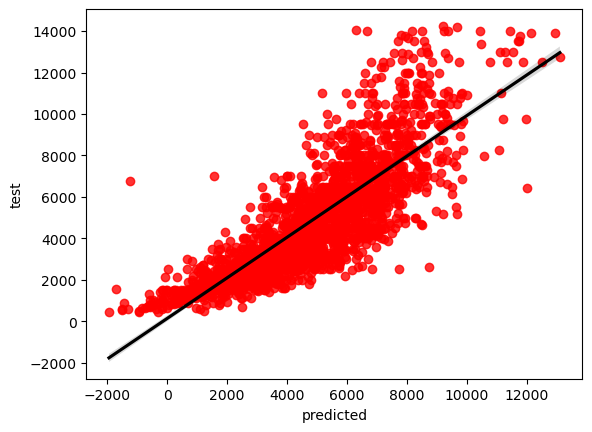

In [38]:
yp = y_pred.to_numpy()
yt = y_test.to_numpy()

plot = sns.regplot(x=yp,y=yt,scatter_kws={"color": "red"}, line_kws={"color": "black"})
plot.set(xlabel='predicted', ylabel='test')